<a href="https://colab.research.google.com/github/smanishs175/MultiLabelTextClassification/blob/main/Manishmultilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt


In [ ]:
toxic_comments = pd.read_csv("/content/drive/MyDrive/NLP mini project/toxic_comments.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(toxic_comments.shape)

toxic_comments.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [ ]:
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [ ]:
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [ ]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


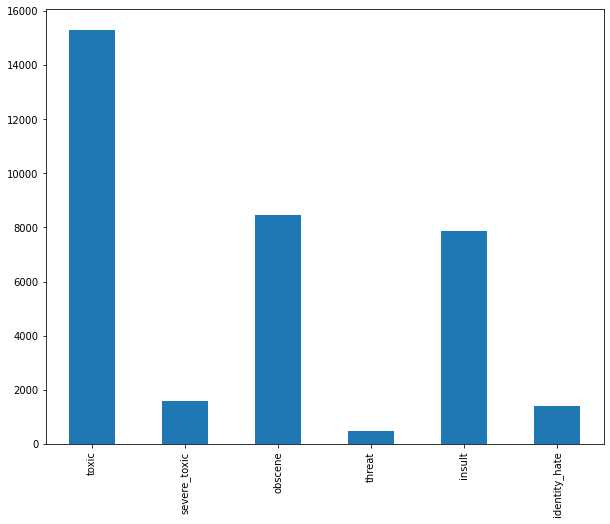

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
text_test=X_test

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/NLP mini project/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          14824300  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


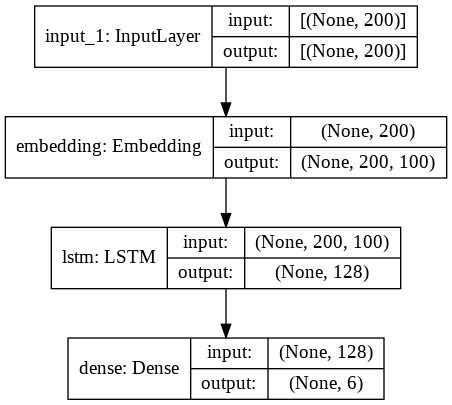

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 [==============================] - 537s 670ms/step - loss: 0.1789 - acc: 0.9820 - val_loss: 0.1413 - val_acc: 0.9943
Epoch 2/5
798/798 [==============================] - 542s 679ms/step - loss: 0.1218 - acc: 0.9937 - val_loss: 0.1265 - val_acc: 0.9942
Epoch 3/5
798/798 [==============================] - 538s 675ms/step - loss: 0.1012 - acc: 0.9937 - val_loss: 0.0703 - val_acc: 0.9943
Epoch 4/5
798/798 [==============================] - 545s 683ms/step - loss: 0.0683 - acc: 0.9942 - val_loss: 0.0670 - val_acc: 0.9943
Epoch 5/5
798/798 [==============================] - 542s 680ms/step - loss: 0.0643 - acc: 0.9940 - val_loss: 0.0606 - val_acc: 0.9943


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 65s 65ms/step - loss: 0.0591 - acc: 0.9941
Test Score: 0.05910894274711609
Test Accuracy: 0.9941093325614929


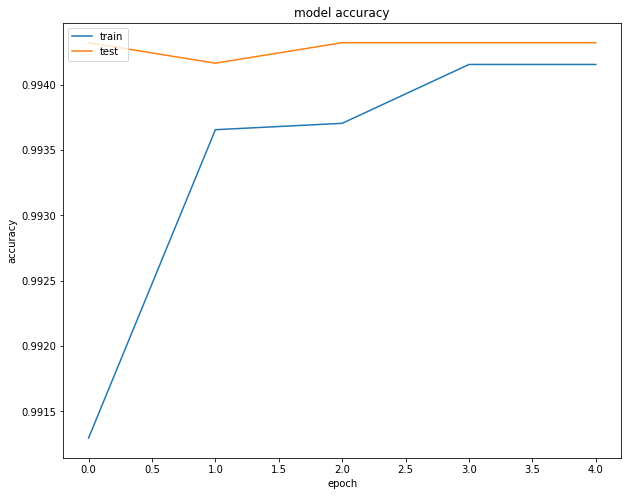

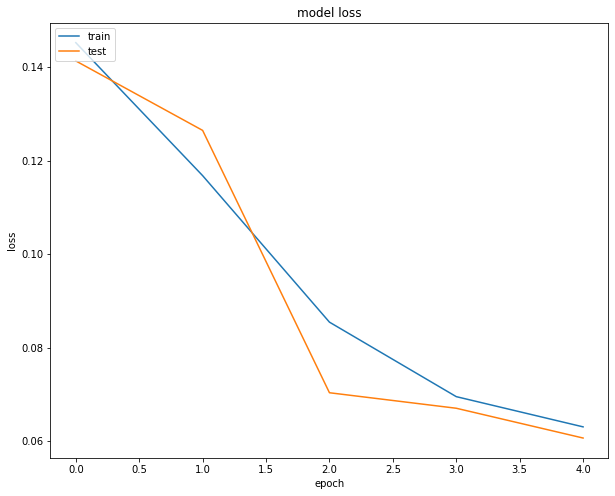

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
test_predictions=model.predict(X_test)

In [ ]:
test_predictions_int=test_predictions.astype(int)

In [ ]:
test_predictions[39]

array([0.9796369 , 0.28279823, 0.91995466, 0.08311972, 0.84994715,
       0.17790368], dtype=float32)

In [ ]:
y_test[39]

array([1, 0, 1, 0, 1, 0])

In [ ]:
text_test[39]

'You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk JACKASS '

In [ ]:
predict_sen=["You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk You re jerk JACKASS "]
predict_sen[0]
abc=list(predict_sen)


In [ ]:
predict_sen1=preprocess_text(abc[0])
p=[predict_sen1]
q=list(p)
predict_sen2 = tokenizer.texts_to_sequences(q)
predict_sen2 = pad_sequences(predict_sen2, padding='post', maxlen=maxlen)
test_predict=model.predict(predict_sen2)
test_predict[0]

array([0.9796369 , 0.28279817, 0.91995454, 0.08311972, 0.8499471 ,
       0.17790368], dtype=float32)

In [ ]:
test_predict[0]

array([0.9796369 , 0.28279817, 0.91995454, 0.08311972, 0.8499471 ,
       0.17790368], dtype=float32)

In [ ]:
com=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
def predict123(v):
  flag=0
  for x in range(6):
    if v[x]>=0.5:
      print(com[x])
      flag=1
  if flag==0:
    print("neutral sentence")  

In [ ]:
predictsen=["Shut up idiot"]
abcd=list(predictsen)
predictsen1=preprocess_text(abcd[0])
pt=[predictsen1]
qt=list(pt)
predictsen2 = tokenizer.texts_to_sequences(qt)
predictsen2 = pad_sequences(predictsen2, padding='post', maxlen=maxlen)
testpredict=model.predict(predictsen2)
testpredict[0]
predict123(testpredict[0])


toxic
obscene
insult
